# DATASET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

# Constants
DATA_DIR = '/content/drive/MyDrive/CASIA-FASD-SHORT'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Custom dataset class to handle image loading and transformations
class CASIADataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load images and labels
def load_images(data_dir):
    image_paths = []
    labels = []
    for label_type in ['live', 'spoof']:
        folder = os.path.join(data_dir, label_type)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            image_paths.append(img_path)
            labels.append(0 if label_type == 'live' else 1)
    return image_paths, labels

# Load images
train_image_paths, train_labels = load_images(os.path.join(DATA_DIR, 'train'))
test_image_paths, test_labels = load_images(os.path.join(DATA_DIR, 'test'))

# Combine images and labels
all_image_paths = train_image_paths + test_image_paths
all_labels = train_labels + test_labels

print(all_image_paths[-5:])
print(all_labels[-5:])
print(all_image_paths[:5])
print(all_labels[:5])

['/content/drive/MyDrive/CASIA-FASD-SHORT/test/spoof/s1v4f186.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/test/spoof/s1v3f111.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/test/spoof/s1v6f142.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/test/spoof/s1v4f167.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/test/spoof/s1v5f44.png']
[1, 1, 1, 1, 1]
['/content/drive/MyDrive/CASIA-FASD-SHORT/train/live/bs3v1f138.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/train/live/bs1v1f0.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/train/live/bs3v2f92.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/train/live/bs2v1f47.png', '/content/drive/MyDrive/CASIA-FASD-SHORT/train/live/bs1v1f143.png']
[0, 0, 0, 0, 0]


In [34]:
# Split live and spoof images
def split_data_by_label(image_paths, labels, val_size=0.2, test_size=0.2, random_state=42):
    live_image_paths = [img for img, label in zip(image_paths, labels) if label == 0]
    spoof_image_paths = [img for img, label in zip(image_paths, labels) if label == 1]

    live_train_paths, live_temp_paths, live_train_labels, live_temp_labels = train_test_split(
        live_image_paths, [0] * len(live_image_paths), test_size=(val_size + test_size), random_state=random_state
    )
    spoof_train_paths, spoof_temp_paths, spoof_train_labels, spoof_temp_labels = train_test_split(
        spoof_image_paths, [1] * len(spoof_image_paths), test_size=(val_size + test_size), random_state=random_state
    )

    live_val_paths, live_test_paths, live_val_labels, live_test_labels = train_test_split(
        live_temp_paths, live_temp_labels, test_size=(test_size / (val_size + test_size)), random_state=random_state
    )
    spoof_val_paths, spoof_test_paths, spoof_val_labels, spoof_test_labels = train_test_split(
        spoof_temp_paths, spoof_temp_labels, test_size=(test_size / (val_size + test_size)), random_state=random_state
    )

    train_paths = live_train_paths + spoof_train_paths
    train_labels = live_train_labels + spoof_train_labels
    val_paths = live_val_paths + spoof_val_paths
    val_labels = live_val_labels + spoof_val_labels
    test_paths = live_test_paths + spoof_test_paths
    test_labels = live_test_labels + spoof_test_labels

    return train_paths, train_labels, val_paths, val_labels, test_paths, test_labels

train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = split_data_by_label(all_image_paths, all_labels)

# Create datasets
train_dataset = CASIADataset(train_paths, train_labels, transform=transform)
val_dataset = CASIADataset(val_paths, val_labels, transform=transform)
test_dataset = CASIADataset(test_paths, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Print the length of each dataset
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 2406
Validation set size: 802
Test set size: 802


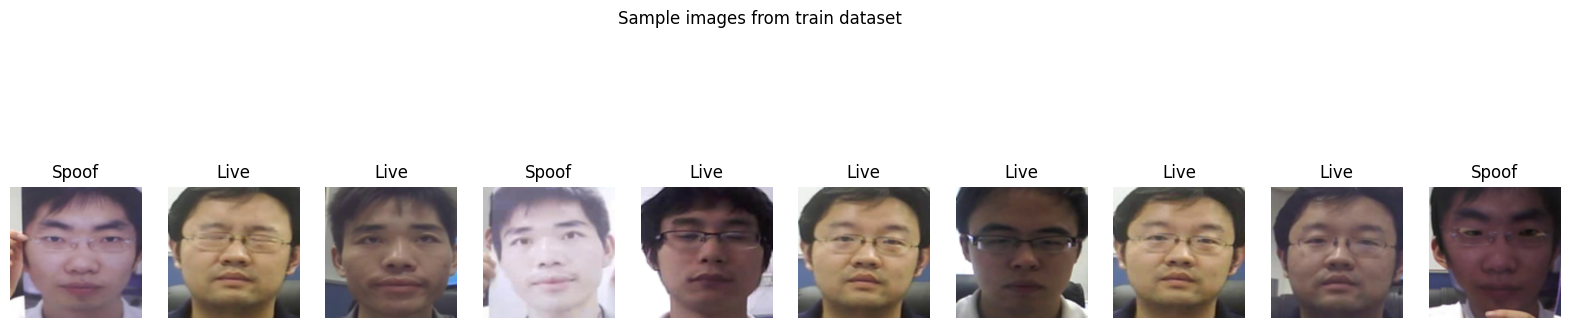

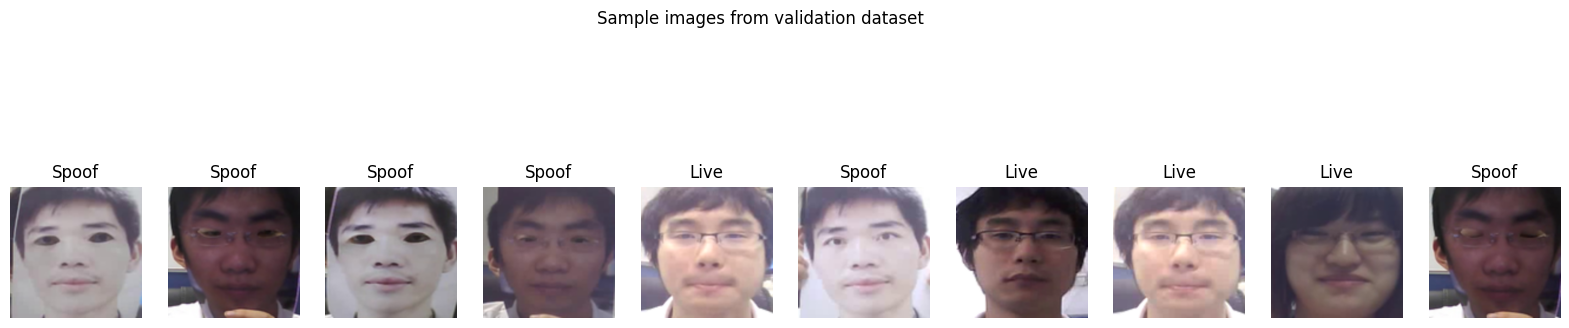

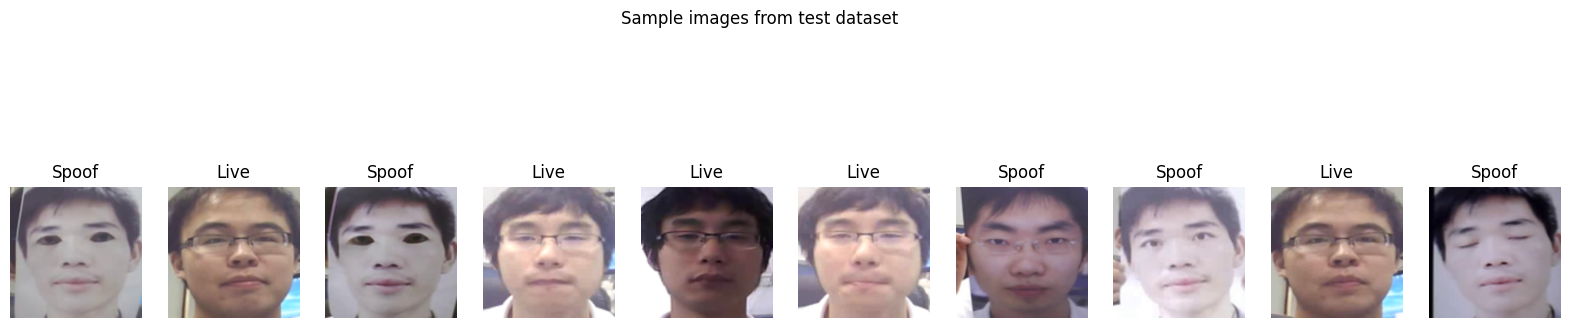

In [35]:
# Function to show images from data loaders
def show_images(loader, dataset_type='train', num_images=10):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Denormalize the images
    images = images * torch.tensor(STD).view(1, 3, 1, 1) + torch.tensor(MEAN).view(1, 3, 1, 1)

    # Convert images to numpy for display
    images = images.numpy().transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for idx in range(num_images):
        ax = axes[idx]
        ax.imshow(np.clip(images[idx], 0, 1))  # Clip values to valid range [0, 1]
        ax.set_title('Live' if labels[idx].item() == 0 else 'Spoof')
        ax.axis('off')

    plt.suptitle(f'Sample images from {dataset_type} dataset')
    plt.show()

# Show images from training, validation and test sets
show_images(train_loader, dataset_type='train')
show_images(val_loader, dataset_type='validation')
show_images(test_loader, dataset_type='test')

# Deep Learning Model

In [36]:
# Define the model using the LivenessNet architecture
class LivenessNet:
    @staticmethod
    def build(width, height, depth, classes):
        input_shape = (height, width, depth)
        chan_dim = -1

        if tf.keras.backend.image_data_format() == 'channels_first':
            input_shape = (depth, height, width)
            chan_dim = 1

        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
            tf.keras.layers.BatchNormalization(axis=chan_dim),
            tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chan_dim),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chan_dim),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chan_dim),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(classes, activation='softmax')
        ])

        return model

Epoch 1/10
75/76 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 [==============================] - 25s 286ms/step - loss: 0.0829 - accuracy: 0.9692 - val_loss: 2.0487 - val_accuracy: 0.6870
Epoch 2/10
76/76 [==============================] - 22s 286ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 4.4241 - val_accuracy: 0.7132
Epoch 3/10
76/76 [==============================] - 26s 338ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 4.5706 - val_accuracy: 0.7594
Epoch 4/10
76/76 [==============================] - 20s 264ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.9854 - val_accuracy: 0.8591
Epoch 5/10
76/76 [==============================] - 22s 286ms/step - loss: 6.5706e-04 - accuracy: 1.0000 - val_loss: 1.3845 - val_accuracy: 0.9227
Epoch 6/10
76/76 [==============================] - 20s 268ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0609 - val_accuracy: 0.9726
Epoch 7/10
76/76 [==============================] - 22s 285ms/step - loss: 4.7368e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Ep

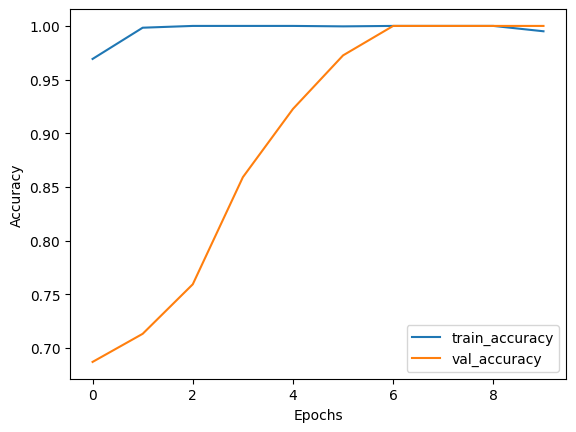

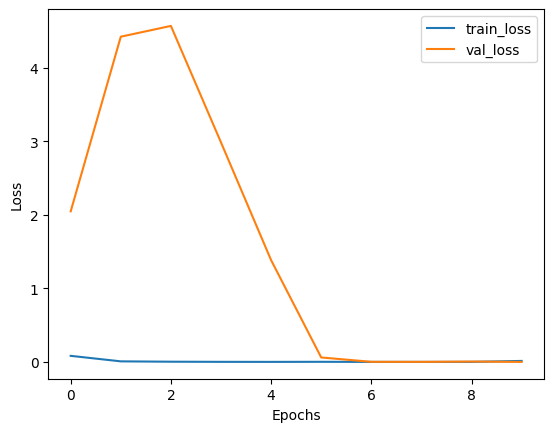

In [37]:
# Prepare model training
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
num_classes = 2

model = LivenessNet.build(width=IMAGE_SIZE[0], height=IMAGE_SIZE[1], depth=3, classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('liveness_model.h5', monitor='val_loss', save_best_only=True)

# Prepare data generators
def generator(loader):
    while True:
        for images, labels in loader:
            yield images.permute(0, 2, 3, 1).numpy(), labels.numpy()

train_gen = generator(train_loader)
val_gen = generator(val_loader)

# Training the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_loader),
    validation_data=val_gen,
    validation_steps=len(val_loader),
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

# Save the model
model.save('liveness_model_final.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
# Prepare test data generator
test_gen = generator(test_loader)

# Load the best model weights
model.load_weights('liveness_model.h5')

# Evaluate the model on test data
test_steps = len(test_loader)
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

26/26 [==============================] - 5s 180ms/step - loss: 1.6550e-04 - accuracy: 1.0000
Test Loss: 0.0002
Test Accuracy: 1.0000


1/1 [==============================] - 0s 132ms/step


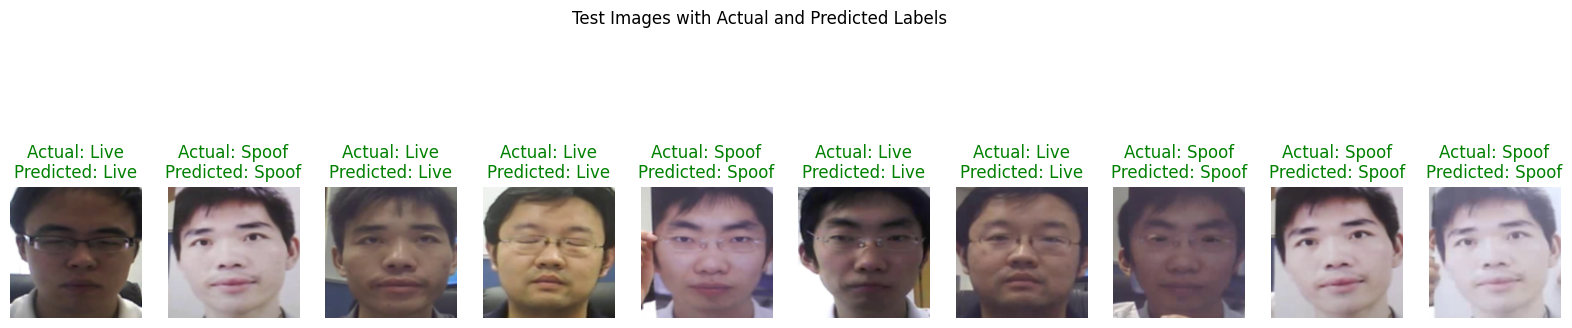

In [39]:
# Generate a batch of test images and labels
test_images, test_labels = next(iter(test_loader))

# Make predictions
predictions = model.predict(test_images.permute(0, 2, 3, 1).numpy())
predicted_labels = np.argmax(predictions, axis=1)

# Extract liveness scores for the live class (assuming live is class 0)
liveness_scores = predictions[:, 0]

# Denormalize the images for display
test_images = test_images * torch.tensor(STD).view(1, 3, 1, 1) + torch.tensor(MEAN).view(1, 3, 1, 1)
test_images = test_images.numpy().transpose((0, 2, 3, 1))

# Function to show test images with actual and predicted labels
def show_test_images(images, actual_labels, predicted_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for idx in range(num_images):
        ax = axes[idx]
        ax.imshow(np.clip(images[idx], 0, 1))  # Clip values to valid range [0, 1]
        title_color = 'green' if actual_labels[idx] == predicted_labels[idx] else 'red'
        ax.set_title(f'Actual: {"Live" if actual_labels[idx] == 0 else "Spoof"}\nPredicted: {"Live" if predicted_labels[idx] == 0 else "Spoof"}', color=title_color)
        ax.axis('off')

    plt.suptitle('Test Images with Actual and Predicted Labels')
    plt.show()

# Display the test images with actual and predicted labels
show_test_images(test_images, test_labels.numpy(), predicted_labels)

1/1 [==============================] - 0s 123ms/step


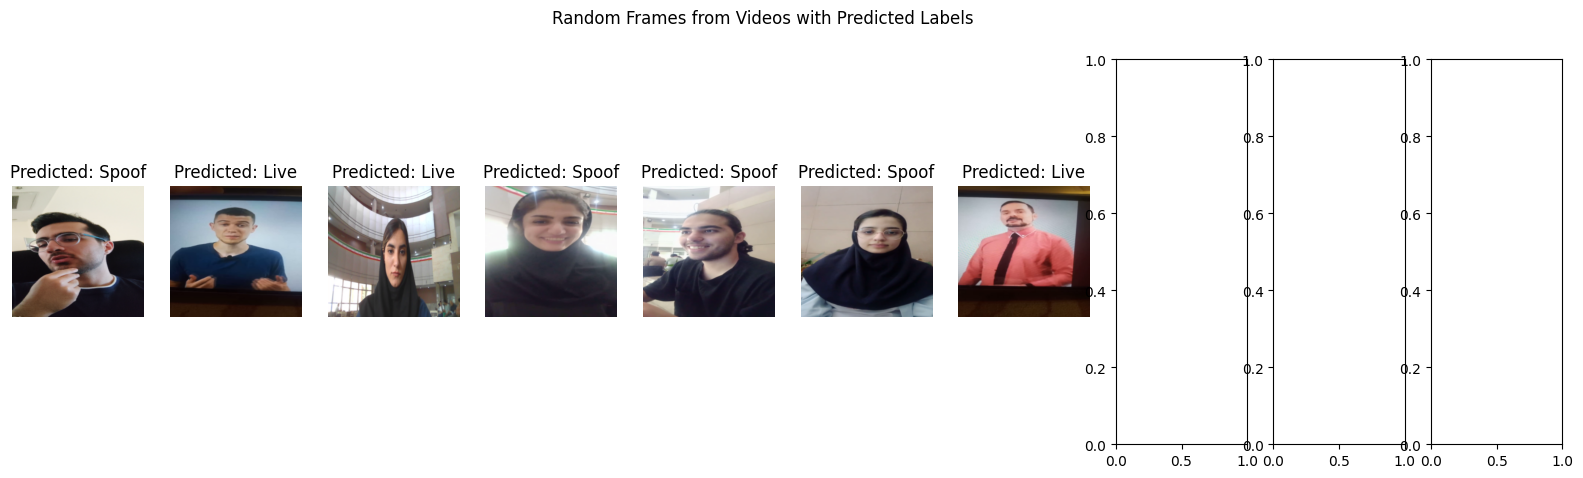

In [57]:
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from torchvision import transforms

# Constants
DATA_DIR = '/content/drive/MyDrive/Videos'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Function to extract a random frame from a video
def extract_random_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        return None
    random_frame = random.randint(0, frame_count - 1)
    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        return None
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

# Read videos and extract frames
video_paths = [os.path.join(DATA_DIR, vid) for vid in os.listdir(DATA_DIR) if vid.endswith(('.mp4', '.avi'))]
frames = []
for video_path in video_paths:
    frame = extract_random_frame(video_path)
    if frame is not None:
        frames.append(frame)

# Preprocess the frames
transformed_frames = []
for frame in frames:
    frame_pil = Image.fromarray(frame)
    transformed_frame = transform(frame_pil).unsqueeze(0)  # Add batch dimension
    transformed_frames.append(transformed_frame)

# Convert list of tensors to a single tensor
transformed_frames = torch.cat(transformed_frames, dim=0)

# Load the trained model
model = tf.keras.models.load_model('liveness_model_final.h5')

# Predict the frames
predictions = model.predict(transformed_frames.permute(0, 2, 3, 1).numpy())
predicted_labels = np.argmax(predictions, axis=1)

# Denormalize the images for display
denormalized_frames = transformed_frames * torch.tensor(STD).view(1, 3, 1, 1) + torch.tensor(MEAN).view(1, 3, 1, 1)
denormalized_frames = denormalized_frames.numpy().transpose((0, 2, 3, 1))

# Function to show images with predicted labels
def show_video_frames_with_predictions(images, predicted_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for idx in range(min(num_images, len(images))):
        ax = axes[idx]
        ax.imshow(np.clip(images[idx], 0, 1))  # Clip values to valid range [0, 1]
        ax.set_title('Predicted: {}'.format('Live' if predicted_labels[idx] == 0 else 'Spoof'))
        ax.axis('off')

    plt.suptitle('Random Frames from Videos with Predicted Labels')
    plt.show()

# Display the frames with predicted labels
show_video_frames_with_predictions(denormalized_frames, predicted_labels)

# ANTI - SPOOFING WITH THE TEXTURE OF AN IMAGE:


In [44]:
import cv2
import numpy as np
from scipy.fftpack import fft2, fftshift

def extract_frequency_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    f_transform = fft2(gray_image)
    f_transform_shifted = fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    return magnitude_spectrum.flatten()

In [45]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, P=8, R=1):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray_image, P=P, R=R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

In [46]:
def extract_features(image):
    frequency_features = extract_frequency_features(image)
    lbp_features = extract_lbp_features(image)
    combined_features = np.concatenate((frequency_features, lbp_features))
    return combined_features

In [49]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class FeatureDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        # Extract features
        features = extract_features(image)

        label = self.labels[idx]

        # Convert to PyTorch tensor if necessary
        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return features, label


# Create feature datasets
train_feature_dataset = FeatureDataset(train_paths, train_labels)
val_feature_dataset = FeatureDataset(val_paths, val_labels)
test_feature_dataset = FeatureDataset(test_paths, test_labels)

# Create data loaders
train_feature_loader = DataLoader(train_feature_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_feature_loader = DataLoader(val_feature_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_feature_loader = DataLoader(test_feature_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [51]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create feature datasets
train_feature_dataset = FeatureDataset(train_paths, train_labels)
val_feature_dataset = FeatureDataset(val_paths, val_labels)
test_feature_dataset = FeatureDataset(test_paths, test_labels)

# Example batch size
BATCH_SIZE = 32

# Create data loaders
train_feature_loader = DataLoader(train_feature_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_feature_loader = DataLoader(val_feature_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_feature_loader = DataLoader(test_feature_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Extract features and labels for training
train_features = []
train_labels = []
for batch_features, batch_labels in train_feature_loader:
    train_features.append(batch_features.numpy())
    train_labels.append(batch_labels.numpy())
train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Train a classifier (example using SVM)
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features, train_labels)

# Validation
val_features = []
val_labels = []
for batch_features, batch_labels in val_feature_loader:
    val_features.append(batch_features.numpy())
    val_labels.append(batch_labels.numpy())
val_features = np.concatenate(val_features, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

val_predictions = svm_classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.4975
